In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline

2025-03-14 11:19:06.953368: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 11:19:06.953986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 11:19:06.956295: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-14 11:19:06.962630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741918746.972760    9928 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741918746.97

In [20]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images as is - before any pre-processing'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [21]:
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from a dataframe with index - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)

In [22]:
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from an array dataset - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [24]:
train_dir = './train_face_data'
test_dir = './test_face_data'
categories = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
label_map = {0: 'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}

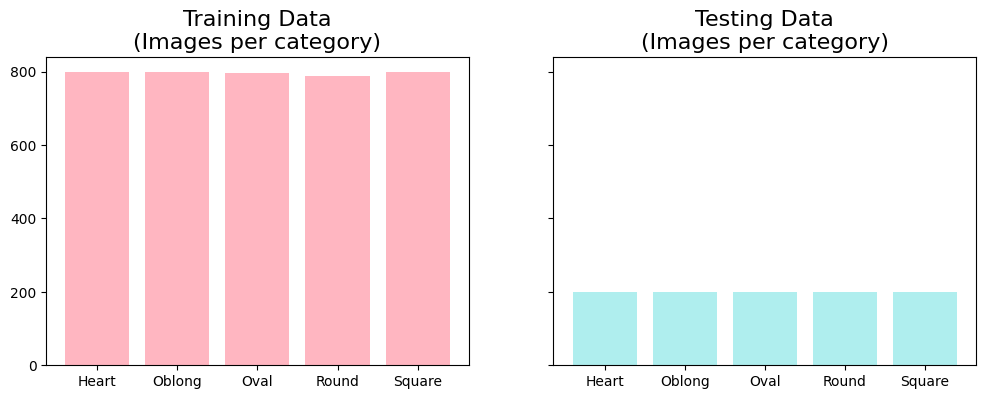

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='lightpink')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='paleturquoise')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,801,200));

In [9]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

## 이미지 크기 비율 처리 

In [10]:
print_summary(training_data, testing_data)


Training Dataset:

Shape: (3981, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [798 798 797 789 799]
Max Pixels: 254

--------------------------------------


Testing Dataset:

Shape: (998, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [200 200 199 199 200]
Max Pixels: 239

--------------------------------------



In [11]:
print(f"Max pixel value in training data: {np.max(X_train)}")
print(f"Max pixel value in testing data: {np.max(X_test)}")

Max pixel value in training data: 255
Max pixel value in testing data: 255


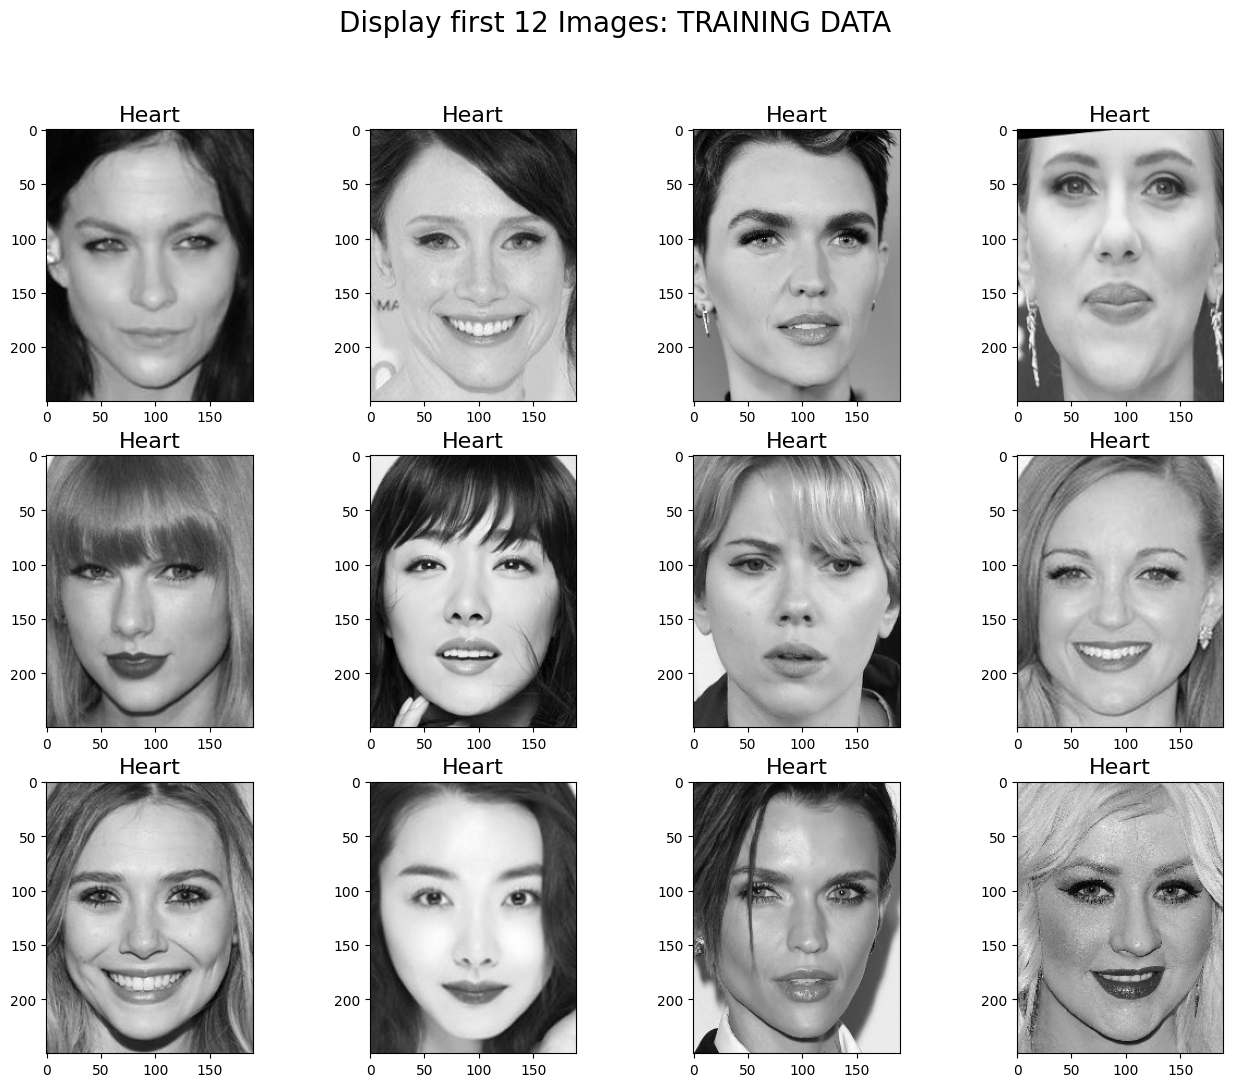

In [12]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', ncols=4)

In [ ]:
#show_img(12, testing_data[:12], 'Display first 12 Images: TESTING DATA', ncols=4)

In [13]:
shape = []

for image, label in training_data:
    try:
        # 이미지의 shape 확인
        if isinstance(image, np.ndarray):  # 이미지가 numpy 배열인지 확인
            img_shape = image.shape
            shape.append(img_shape)
        else:
            print("Invalid image format:", type(image))  # 이미지가 numpy 배열이 아닌 경우 처리
    except AttributeError:
        print("shape not found for an image")

# shape의 첫 5개 출력
print(shape[:5])

[(250, 190), (250, 190), (250, 190), (250, 190), (250, 190)]


In [14]:
train = pd.DataFrame(training_data, columns=['img_array','class'])
train['img_shape'] = pd.Series(shape)
train['face_shape'] = train['class'].map(label_map) 
train.head(2)

img_array class   img_shape  \
0  [[13, 12, 12, 12, 12, 12, 12, 12, 11, 10, 9, 1...     0  (250, 190)   
1  [[75, 70, 57, 63, 69, 69, 64, 60, 60, 62, 58, ...     0  (250, 190)   

  face_shape  
0      Heart  
1      Heart

In [15]:
train.sort_values(by='img_shape', ascending=False)

img_array class   img_shape  \
0     [[13, 12, 12, 12, 12, 12, 12, 12, 11, 10, 9, 1...     0  (250, 190)   
2659  [[217, 203, 195, 191, 190, 194, 204, 198, 185,...     3  (250, 190)   
2646  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...     3  (250, 190)   
2647  [[235, 235, 234, 234, 235, 235, 235, 235, 234,...     3  (250, 190)   
2648  [[61, 61, 60, 59, 58, 57, 57, 57, 57, 57, 59, ...     3  (250, 190)   
...                                                 ...   ...         ...   
1332  [[181, 181, 179, 167, 139, 115, 114, 112, 91, ...     1  (250, 190)   
1333  [[186, 193, 186, 161, 156, 75, 38, 54, 67, 57,...     1  (250, 190)   
1334  [[226, 226, 227, 227, 227, 227, 227, 227, 226,...     1  (250, 190)   
1335  [[184, 132, 146, 118, 111, 130, 124, 116, 99, ...     1  (250, 190)   
3980  [[85, 82, 85, 94, 84, 96, 101, 115, 125, 116, ...     4  (250, 190)   

     face_shape  
0         Heart  
2659      Round  
2646      Round  
2647      Round  
2648      Round  
...         ...  
1332     Oblong  
1333     Oblong  
1334     Oblong  
1335     Oblong  
3980     Square  

[3981 rows x 4 columns]

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3981 entries, 0 to 3980
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_array   3981 non-null   object
 1   class       3981 non-null   object
 2   img_shape   3981 non-null   object
 3   face_shape  3981 non-null   object
dtypes: object(4)
memory usage: 124.5+ KB


In [17]:
train['height'] = train['img_shape'].map(lambda x : x[0])
train['width'] = train['img_shape'].map(lambda x : x[1])
train['aspect_ratio'] = train['width'] / train['height']
train

img_array class   img_shape  \
0     [[13, 12, 12, 12, 12, 12, 12, 12, 11, 10, 9, 1...     0  (250, 190)   
1     [[75, 70, 57, 63, 69, 69, 64, 60, 60, 62, 58, ...     0  (250, 190)   
2     [[118, 85, 116, 114, 65, 58, 49, 20, 12, 2, 15...     0  (250, 190)   
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     0  (250, 190)   
4     [[240, 243, 242, 239, 246, 235, 215, 201, 141,...     0  (250, 190)   
...                                                 ...   ...         ...   
3976  [[185, 176, 172, 172, 169, 135, 110, 106, 102,...     4  (250, 190)   
3977  [[189, 193, 190, 190, 172, 183, 187, 185, 180,...     4  (250, 190)   
3978  [[44, 44, 42, 39, 36, 34, 30, 27, 23, 19, 17, ...     4  (250, 190)   
3979  [[197, 207, 197, 158, 122, 128, 136, 135, 143,...     4  (250, 190)   
3980  [[85, 82, 85, 94, 84, 96, 101, 115, 125, 116, ...     4  (250, 190)   

     face_shape  height  width  aspect_ratio  
0         Heart     250    190          0.76  
1         Heart     250    190          0.76  
2         Heart     250    190          0.76  
3         Heart     250    190          0.76  
4         Heart     250    190          0.76  
...         ...     ...    ...           ...  
3976     Square     250    190          0.76  
3977     Square     250    190          0.76  
3978     Square     250    190          0.76  
3979     Square     250    190          0.76  
3980     Square     250    190          0.76  

[3981 rows x 7 columns]

In [18]:
train.describe()

height   width  aspect_ratio
count  3981.0  3981.0  3.981000e+03
mean    250.0   190.0  7.600000e-01
std       0.0     0.0  1.110362e-16
min     250.0   190.0  7.600000e-01
25%     250.0   190.0  7.600000e-01
50%     250.0   190.0  7.600000e-01
75%     250.0   190.0  7.600000e-01
max     250.0   190.0  7.600000e-01

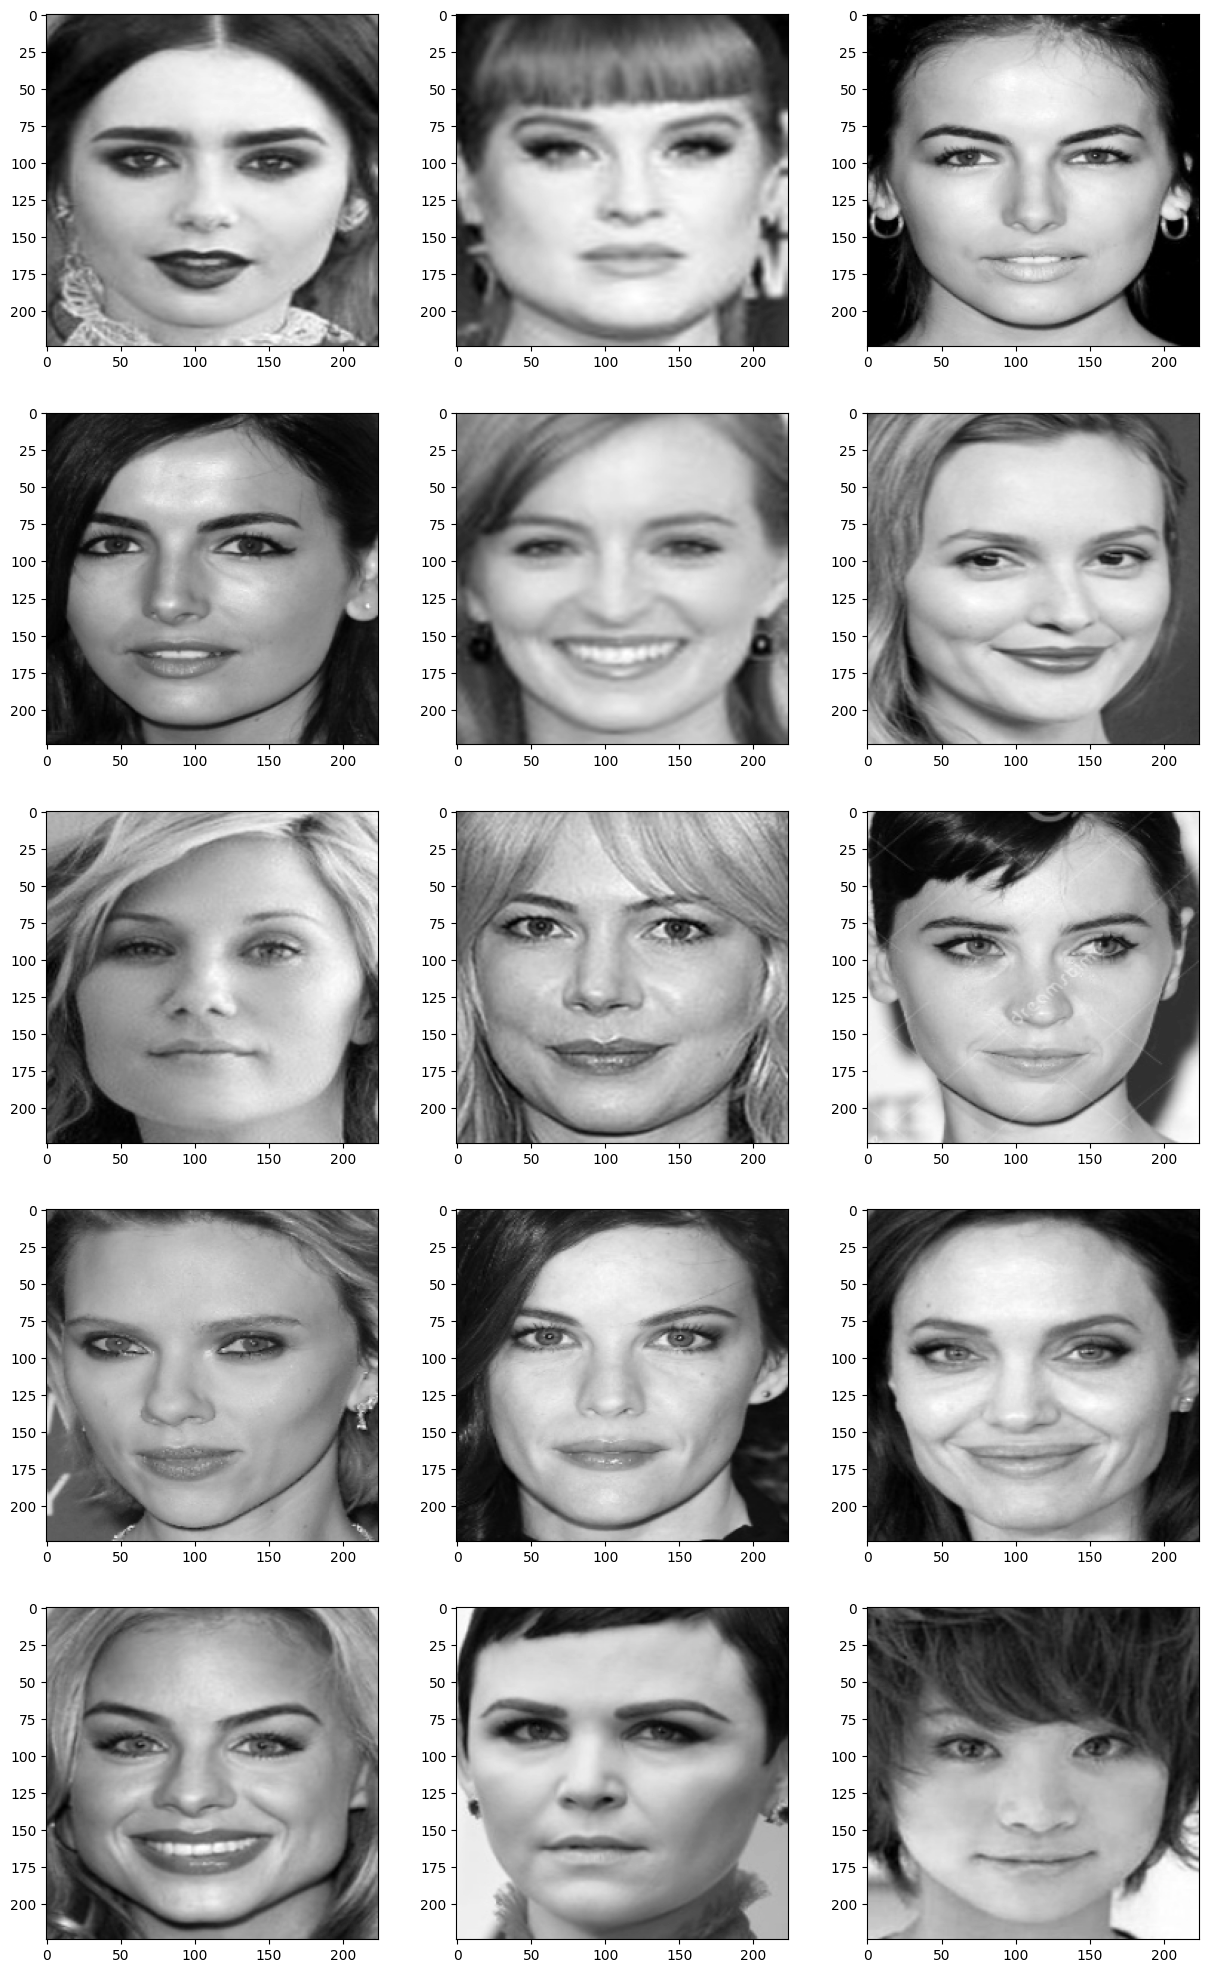

In [19]:
#추가
randomlist = random.sample(range(0, 3998), 15)
img_size = 224
fig, ax = plt.subplots(nrows = 5, ncols=3, figsize = (15,25))
ax = ax.ravel()
for i,img in enumerate(randomlist):
    image = train.loc[img,'img_array']
    new_image = cv2.resize(image, (img_size, img_size))
    ax[i].imshow(new_image, cmap='gray')

In [16]:
#모델링에 필요한 데이터 피클 저장
#이미지 resize : 224 * 224 
def train_test_prep(training_data_array, testing_data_array):
    
    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)
    
    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)  
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [28]:
def pickle_out(X_train, X_test, y_train, y_test, version):
  
    data_path = './face_shape_classification/'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'    
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [22]:
training_data = []
testing_data = []

create_data_files(train_dir, training_data, (224,224))
create_data_files(test_dir, testing_data, (224,224))

In [23]:
X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3981, 224, 224)
X_test.shape (998, 224, 224)
y_train.shape (3981, 5)
y_test.shape (998, 5)


In [24]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3981, 224, 224, 1)
X_test.shape (998, 224, 224, 1)
y_train.shape (3981, 5)
y_test.shape (998, 5)


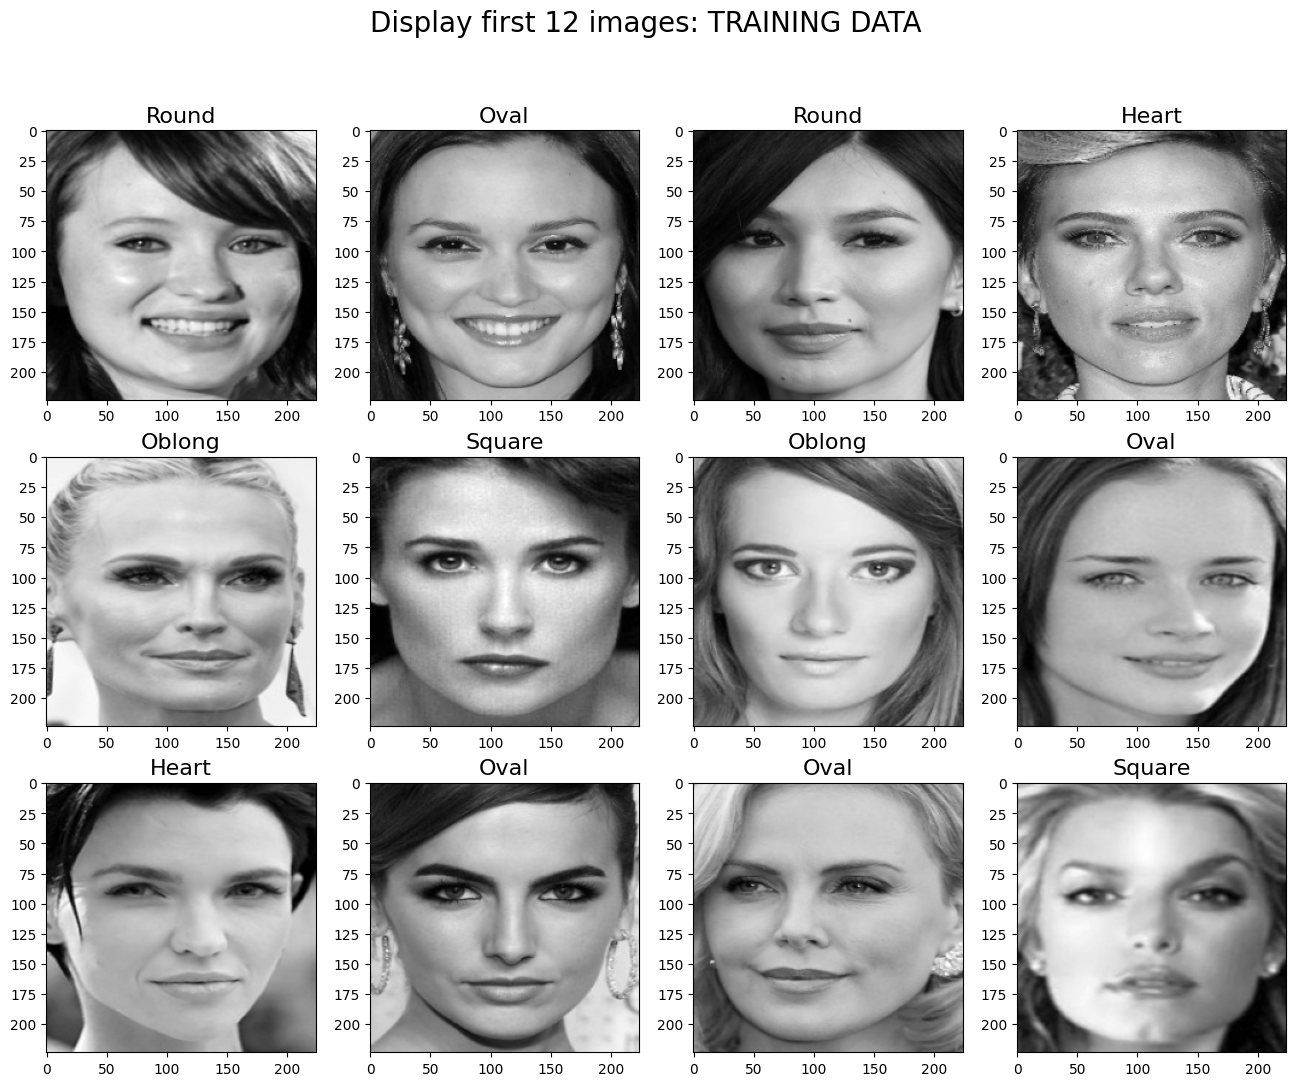

In [25]:
show_img(12, training_data[:12], 'Display first 12 images: TRAINING DATA', ncols=4)

In [ ]:
show_img(12, testing_data[:12], 'Display first 12 images: TESTING DATA', ncols=4)

## 이미지 색상 처리 

In [27]:
import os

# 'examples' 폴더 경로
folder_path = './data_face_shape/examples'

# 이미지 파일 확장자 목록 (필요에 따라 확장자를 추가하거나 수정)
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp']

# 이미지 파일 갯수 세기
image_count = 0

# 폴더 내의 파일들 확인
for filename in os.listdir(folder_path):
    # 파일 경로 만들기
    file_path = os.path.join(folder_path, filename)
    
    # 파일이 실제로 파일인지 확인하고, 이미지 확장자일 경우 카운트
    if os.path.isfile(file_path) and any(filename.lower().endswith(ext) for ext in image_extensions):
        image_count += 1

# 결과 출력
print(f"이미지 파일의 개수: {image_count}")

이미지 파일의 개수: 3981


In [46]:
def create_data_files(directory, array, type=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        
        if type == 'aspect':
            try:
                for img in img_list:            
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)  # read in default color Grayscale
                    img_array = crop_and_resize(img_array) # call a function to crop & resize maintain aspect ratio
                    array.append([img_array, class_num])
                    i += 1
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')
        
        elif type == 'gray':
            try:
                for img in img_list:            
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    gray_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2GRAY) # convert to Gray
                    array.append([gray_array, class_num])   # 0=image, 1=class 
                    i += 1               
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        elif type == 'rgb':
            try:
                for img in img_list:            
                    img_array = cv2.imread(os.path.join(path,img))
                    face_array = extract_face(img_array)  # call function to extract face
                    rgb_array = cv2.cvtColor(face_array,cv2.COLOR_BGR2RGB) # convert to RGB
                    array.append([rgb_array, class_num])   # 0=image, 1=class
                    i += 1                
            except Exception as e:
                    print(f'Error: \n category: {category}\n image: {img}')

        else:
            print("Please specify image type ['aspect', 'gray', 'rgb']")
            break

        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")

In [6]:
def crop_and_resize(image, target_w=224, target_h=224):
    '''this function crop & resize images to target size by keeping aspect ratio'''
    if image.ndim == 2:
        img_h, img_w = image.shape             # for Grayscale will be   img_h, img_w = img.shape
    elif image.ndim == 3:
        img_h, img_w, channels = image.shape   # for RGB will be   img_h, img_w, channels = img.shape
    target_aspect_ratio = target_w/target_h
    input_aspect_ratio = img_w/img_h

    if input_aspect_ratio > target_aspect_ratio:
        resize_w = int(input_aspect_ratio*target_h)
        resize_h = target_h
        img = cv2.resize(image, (resize_w , resize_h))
        crop_left = int((resize_w - target_w)/2)  ## crop left/right equally
        crop_right = crop_left + target_w
        new_img = img[:, crop_left:crop_right]
    if input_aspect_ratio < target_aspect_ratio:
        resize_w = target_w
        resize_h = int(target_w/input_aspect_ratio)
        img = cv2.resize(image, (resize_w , resize_h))
        crop_top = int((resize_h - target_h)/4)   ## crop the top by 1/4 and bottom by 3/4 -- can be changed
        crop_bottom = crop_top + target_h
        new_img = img[crop_top:crop_bottom, :]
    if input_aspect_ratio == target_aspect_ratio:
        new_img = cv2.resize(image, (target_w, target_h))

    return new_img

In [7]:
portrait = cv2.imread(
    './data_face_shape/examples/Heart(0).jpg', 
    cv2.IMREAD_GRAYSCALE)
landscape = cv2.imread(
    './data_face_shape/examples/Oblong(445).jpg',
    cv2.IMREAD_GRAYSCALE)

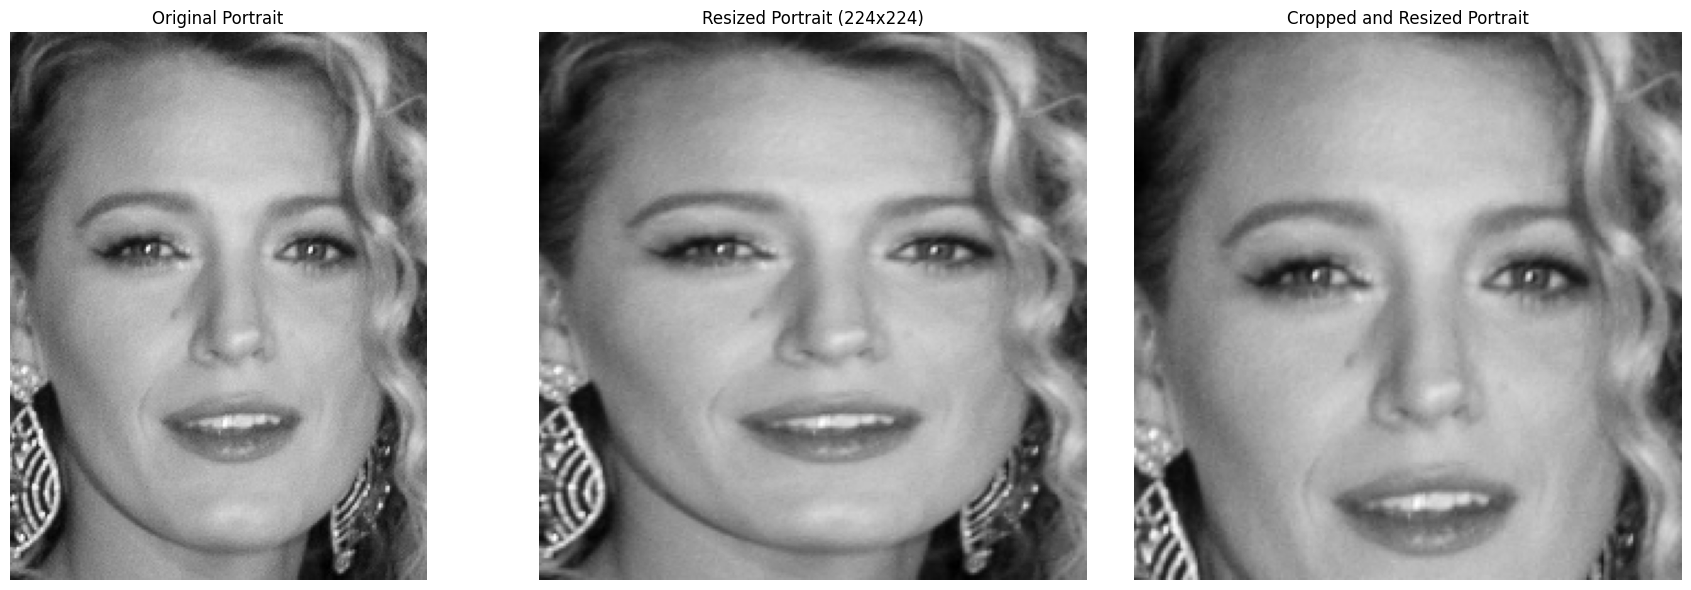

In [34]:
# 2. 리사이즈된 이미지
resized_ptrt = cv2.resize(portrait, (224, 224))

# 3. 크롭 후 리사이즈된 이미지
new_ptrt = crop_and_resize(portrait)

# 이미지 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1행 3열의 서브플롯 생성

# 원본 이미지
axes[0].imshow(portrait, cmap='gray')
axes[0].set_title('Original Portrait')
axes[0].axis('off')  # 축 숨기기

# 리사이즈된 이미지
axes[1].imshow(resized_ptrt, cmap='gray')
axes[1].set_title('Resized Portrait (224x224)')
axes[1].axis('off')

# 크롭 후 리사이즈된 이미지
axes[2].imshow(new_ptrt, cmap='gray')
axes[2].set_title('Cropped and Resized Portrait')
axes[2].axis('off')

# 결과 표시
plt.tight_layout()
plt.show()

In [8]:
#Boxing 기법 활용 
import mtcnn
from mtcnn.mtcnn import MTCNN
img2 = cv2.cvtColor(portrait,cv2.COLOR_BGR2RGB)
detector = MTCNN()
results = detector.detect_faces(img2)
results

2025-03-14 11:19:44.732058: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


[{'box': [15, 14, 163, 214],
  'confidence': np.float64(0.9951967597007751),
  'keypoints': {'nose': [np.int64(103), np.int64(141)],
   'mouth_right': [np.int64(132), np.int64(174)],
   'right_eye': [np.int64(137), np.int64(97)],
   'left_eye': [np.int64(61), np.int64(98)],
   'mouth_left': [np.int64(70), np.int64(176)]}}]

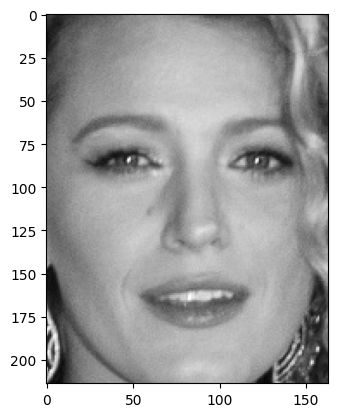

In [37]:
x1, y1, width, height = results[0]['box']
x2, y2 = x1+width, y1+height

face = img2[y1:y2, x1:x2]
plt.imshow(face);

In [6]:
def create_data_from_folders(directory):
    data = []
    labels = []

    # 폴더 내 각 속성 폴더 이름을 찾음 (Heart, Oblong 등)
    attributes = os.listdir(directory)

    for label in attributes:
        label_folder = os.path.join(directory, label)
        
        # 각 속성 폴더가 디렉토리일 경우
        if os.path.isdir(label_folder):
            # 해당 폴더에 있는 모든 이미지 파일을 가져옴
            for filename in os.listdir(label_folder):
                file_path = os.path.join(label_folder, filename)

                # 이미지 파일인지 확인
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(file_path)

                    # 이미지가 제대로 읽어졌다면
                    if img is not None:
                        data.append(img)  # 이미지 데이터를 리스트에 추가
                        labels.append(label)  # 해당 레이블 추가

    return data, labels

In [10]:
def extract_face(img, target_size=(224,224)):
   
    results = detector.detect_faces(img)
    if results == []:
        new_face = crop_and_resize(img, target_w=224, target_h=224)    
    else:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1+width, y1+height
        face = img[y1:y2, x1:x2]

        # 2. expand the top & bottom of bounding box by 10 pixels to ensure it captures the whole face
        adj_h = 10

        #assign value of new y1
        if y1-adj_h <10:
            new_y1=0
        else:
            new_y1 = y1-adj_h

        #assign value of new y2    
        if y1+height+adj_h < img.shape[0]:
            new_y2 = y1+height+adj_h
        else:
            new_y2 = img.shape[0]
        new_height = new_y2 - new_y1

        # 3. crop the image to a square image by setting the width = new_height and expand the box to new width
        adj_w = int((new_height-width)/2)    

        #assign value of new x1
        if x1-adj_w < 0:
            new_x1=0
        else:
            new_x1 = x1-adj_w

        #assign value of new x2
        if x2+adj_w > img.shape[1]:
            new_x2 = img.shape[1]
        else:
            new_x2 = x2+adj_w
        new_face = img[new_y1:new_y2, new_x1:new_x2]  # face-cropped square image based on original resolution

    # 4. resize image to the target pixel size
    sqr_img = cv2.resize(new_face, target_size)   
    return sqr_img

In [11]:
train_dir = './train_face_data/'  # 실제 데이터가 있는 경로
all_data, all_labels = create_data_from_folders(train_dir)

# 이미지 시각화
n_images = 5  # 각 속성별로 1개의 이미지씩 시각화

# 속성 목록
attributes = ["Heart", "Oblong", "Oval", "Round", "Square"]

# 이미지 데이터를 저장할 리스트
all_data = []
all_labels = []

# 속성 폴더에서 이미지 로드 및 라벨 지정
for label in attributes:
    folder_path = os.path.join(train_dir, label)  # 각 속성에 해당하는 폴더 경로
    if os.path.exists(folder_path):  # 폴더가 존재하는지 확인
        for img_name in os.listdir(folder_path):
            # 이미지가 jpg 파일인 경우만 처리
            if img_name.endswith('.jpg'):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)

                # 이미지 로딩 확인
                if img is None:
                    print(f"Warning: Unable to load image at {img_path}")
                else:
                    all_data.append(img)
                    all_labels.append(label)
    else:
        print(f"Warning: Folder for attribute '{label}' does not exist at {folder_path}")
        
fig, ax = plt.subplots(nrows=7, ncols=n_images, figsize=(n_images*2.5, 7*2.5))
plt.gray()

ax = ax.ravel()

for i, label in enumerate(attributes[:n_images]):
    # 해당 레이블에 맞는 이미지 찾기
    label_data = [data for data, lbl in zip(all_data, all_labels) if lbl == label]
    
    if label_data:
        img = label_data[0]  # 해당 속성의 첫 번째 이미지 선택
        
        # 1. 원본 이미지를 리사이즈 후 표시
        rsz_img = cv2.resize(img,(224,224))
        rsz_img = cv2.cvtColor(rsz_img,cv2.COLOR_BGR2GRAY)
        ax[i].imshow(rsz_img)
        ax[i].axis('off')
        #ax[i].set_title(f"{label} - Original", fontsize=12, pad=10)
    
        # 비율을 유지한 채 크롭 후 리사이즈
        aspct_img = crop_and_resize(img, target_w=224, target_h=224)
        aspct_img = cv2.cvtColor(aspct_img, cv2.COLOR_BGR2GRAY)
        ax[i + n_images].imshow(aspct_img)
        ax[i + n_images].axis('off')
        #ax[i + n_images].set_title(f"{label} - Aspect", fontsize=12, pad=10)
    
        # MTCNN으로 추출한 얼굴을 RGB로 변환하여 표시
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i + 2 * n_images].imshow(rgb_img)
        ax[i + 2 * n_images].axis('off')
        #ax[i + 2 * n_images].set_title(f"{label} - RGB", fontsize=12, pad=10)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

# 속성 이름을 이미지 아래에 배치
plt.figtext(x=0.17, y=0.89, s="Heart", fontsize=15)
plt.figtext(x=0.32, y=0.89, s="Oblong", fontsize=15)
plt.figtext(x=0.50, y=0.89, s="Oval", fontsize=15)
plt.figtext(x=0.64, y=0.89, s="Round", fontsize=15)
plt.figtext(x=0.80, y=0.89, s="Square", fontsize=15)
#for i, attribute in enumerate(attributes[:n_images]):
#    plt.figtext(x=0.16, y=0.89, s=attribute, fontsize=15) 
    
# 폰트 설정 및 라벨 추가
plt.figtext(x=0.105, y=0.8, s="Auto Resize", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.68, s="w/Aspect Ratio", fontsize=15, rotation=90)
plt.figtext(x=0.105, y=0.6, s="BBox", fontsize=15, rotation=90)

plt.show()

NameError: name 'create_data_from_folders' is not defined

In [5]:
def create_data_files(directory, array, type=None):
    i = 0  # 변수 초기화
    failed_images = []  # 실패한 이미지를 기록할 리스트
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the categories
        img_list = os.listdir(path)
        
        if type == 'aspect':
            try:
                for img in img_list:            
                    img_path = os.path.join(path, img)
                    if not os.path.exists(img_path):  # 이미지 파일이 존재하는지 확인
                        print(f"Warning: Image not found at {img_path}")
                        continue
                    
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # read in grayscale
                    if img_array is None:
                        print(f"Error: Unable to load image at {img_path}")
                        failed_images.append(img_path)  # 실패한 이미지를 기록
                        continue
                        
                    img_array = crop_and_resize(img_array)  # call a function to crop & resize
                    array.append([img_array, class_num])
                    i += 1
            except Exception as e:
                print(f'Error in aspect processing: \n category: {category}\n image: {img}, error: {e}')
        
        elif type == 'gray':
            try:
                for img in img_list:            
                    img_path = os.path.join(path, img)
                    if not os.path.exists(img_path):  # 이미지 파일이 존재하는지 확인
                        print(f"Warning: Image not found at {img_path}")
                        continue
                    
                    img_array = cv2.imread(img_path)
                    if img_array is None:
                        print(f"Error: Unable to load image at {img_path}")
                        failed_images.append(img_path)  # 실패한 이미지를 기록
                        continue
                    
                    face_array = extract_face(img_array)  # 얼굴 추출 함수
                    gray_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)  # Gray 변환
                    array.append([gray_array, class_num])  # 0=image, 1=class 
                    i += 1               
            except Exception as e:
                print(f'Error in gray processing: \n category: {category}\n image: {img}, error: {e}')

        elif type == 'rgb':
            try:
                for img in img_list:            
                    img_path = os.path.join(path, img)
                    if not os.path.exists(img_path):  # 이미지 파일이 존재하는지 확인
                        print(f"Warning: Image not found at {img_path}")
                        continue
                    
                    img_array = cv2.imread(img_path)
                    if img_array is None:
                        print(f"Error: Unable to load image at {img_path}")
                        failed_images.append(img_path)  # 실패한 이미지를 기록
                        continue
                    
                    face_array = extract_face(img_array)  # 얼굴 추출 함수
                    rgb_array = cv2.cvtColor(face_array, cv2.COLOR_BGR2RGB)  # RGB 변환
                    array.append([rgb_array, class_num])  # 0=image, 1=class
                    i += 1                
            except Exception as e:
                print(f'Error in rgb processing: \n category: {category}\n image: {img}, error: {e}')

        else:
            print("Please specify image type ['aspect', 'gray', 'rgb']")
            break

        # Print progress every 200 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list) * len(categories)}")

    # 실패한 이미지 리스트 출력
    if failed_images:
        print("\nFailed to load the following images:")
        for failed_img in failed_images:
            print(failed_img)

In [12]:
training_data_gray = []
testing_data_gray = []

train_dir = './train_face_data'  # 실제 데이터가 있는 경로
test_dir = './test_face_data'    # 테스트 데이터 경로
categories = ['Heart', 'Oblong', 'Oval', 'Round', 'Square'] 

create_data_files(train_dir, training_data_gray, 'gray')
create_data_files(test_dir, testing_data_gray, 'gray')

2025-03-14 11:21:25.550508: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]
2025-03-14 11:21:33.390757: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]
2025-03-14 11:21:53.783760: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]
2025-03-14 11:24:43.198681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


Images processed: 200 of 1000
Images processed: 400 of 1000


2025-03-14 11:28:08.474925: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0,48,48,3] vs. [1,1,1,32]


In [13]:
print(len(training_data_gray))

3981


In [14]:
print(len(testing_data_gray))

998


In [17]:
X_train, X_test, y_train, y_test = train_test_prep(training_data_gray, testing_data_gray)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3981, 224, 224)
X_test.shape (998, 224, 224)
y_train.shape (3981, 5)
y_test.shape (998, 5)


In [18]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (3981, 224, 224, 1)
X_test.shape (998, 224, 224, 1)
y_train.shape (3981, 5)
y_test.shape (998, 5)


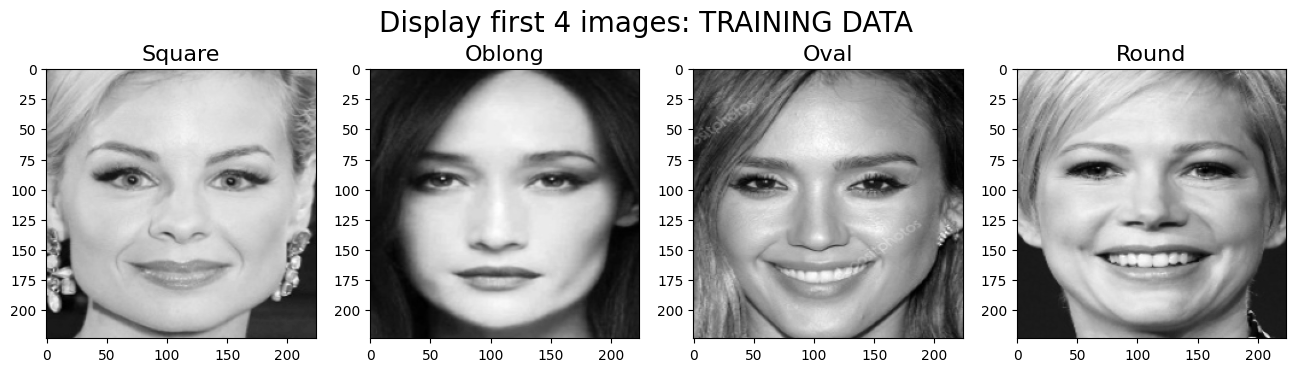

In [25]:
show_img(4, training_data_gray[4:], 'Display first 4 images: TRAINING DATA', ncols=4)

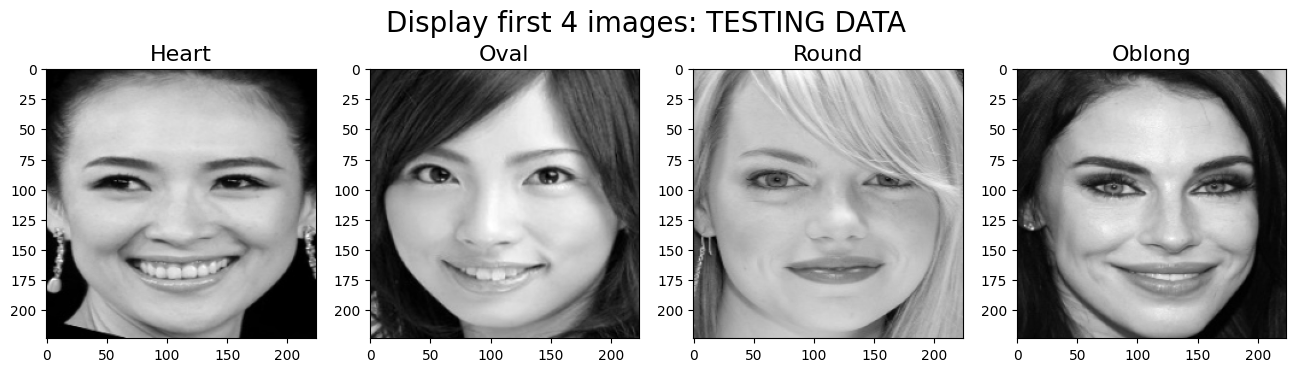

In [26]:
show_img(4, testing_data_gray[:4], 'Display first 4 images: TESTING DATA', ncols=4)

In [29]:
pickle_out(X_train, X_test, y_train, y_test, 'gray')

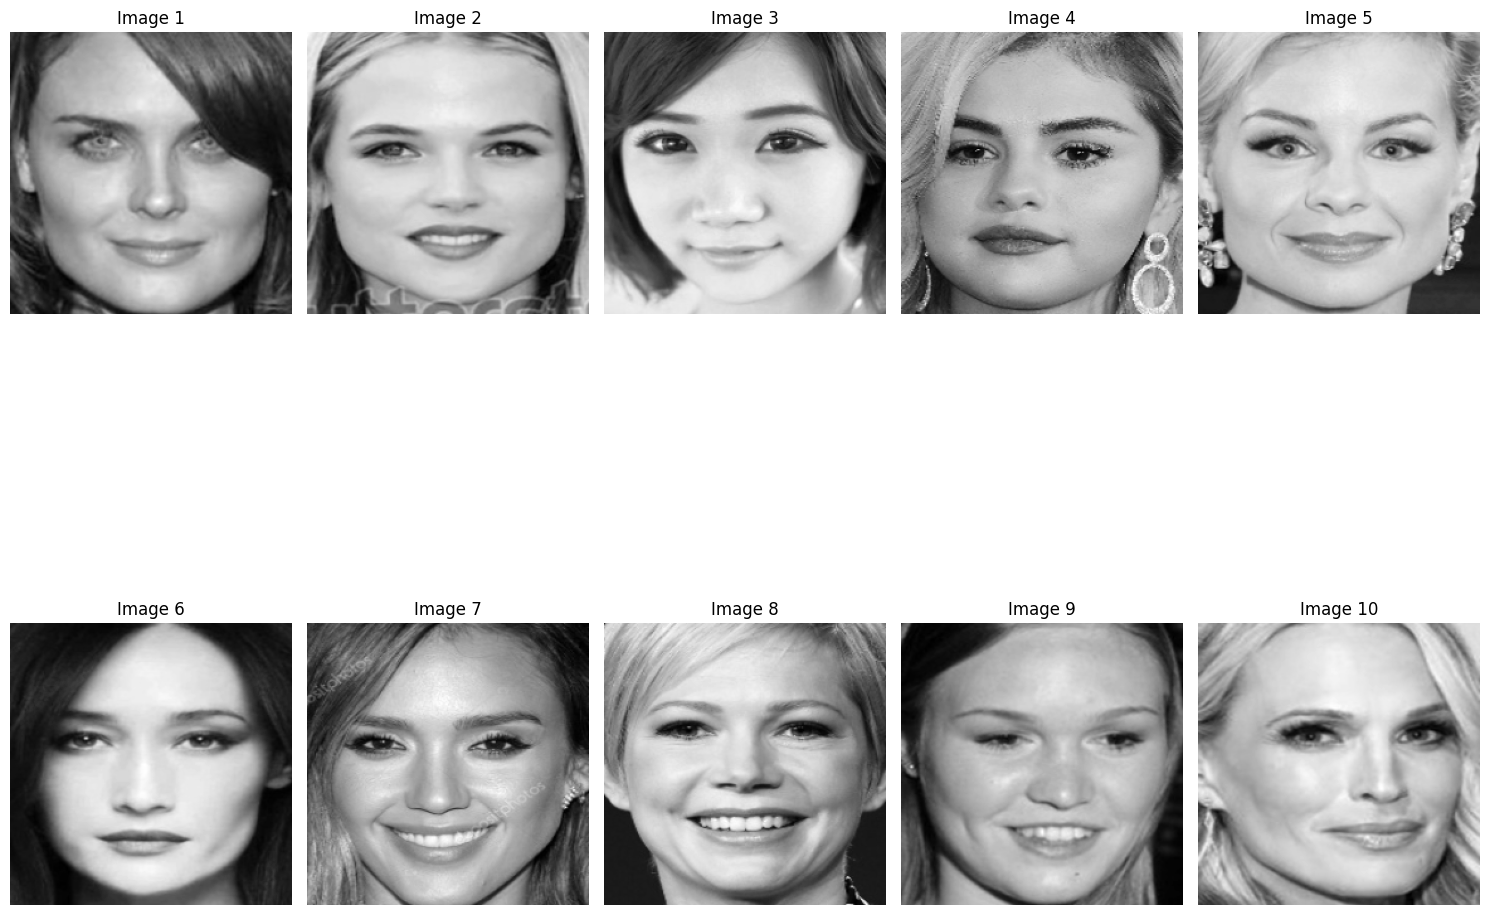

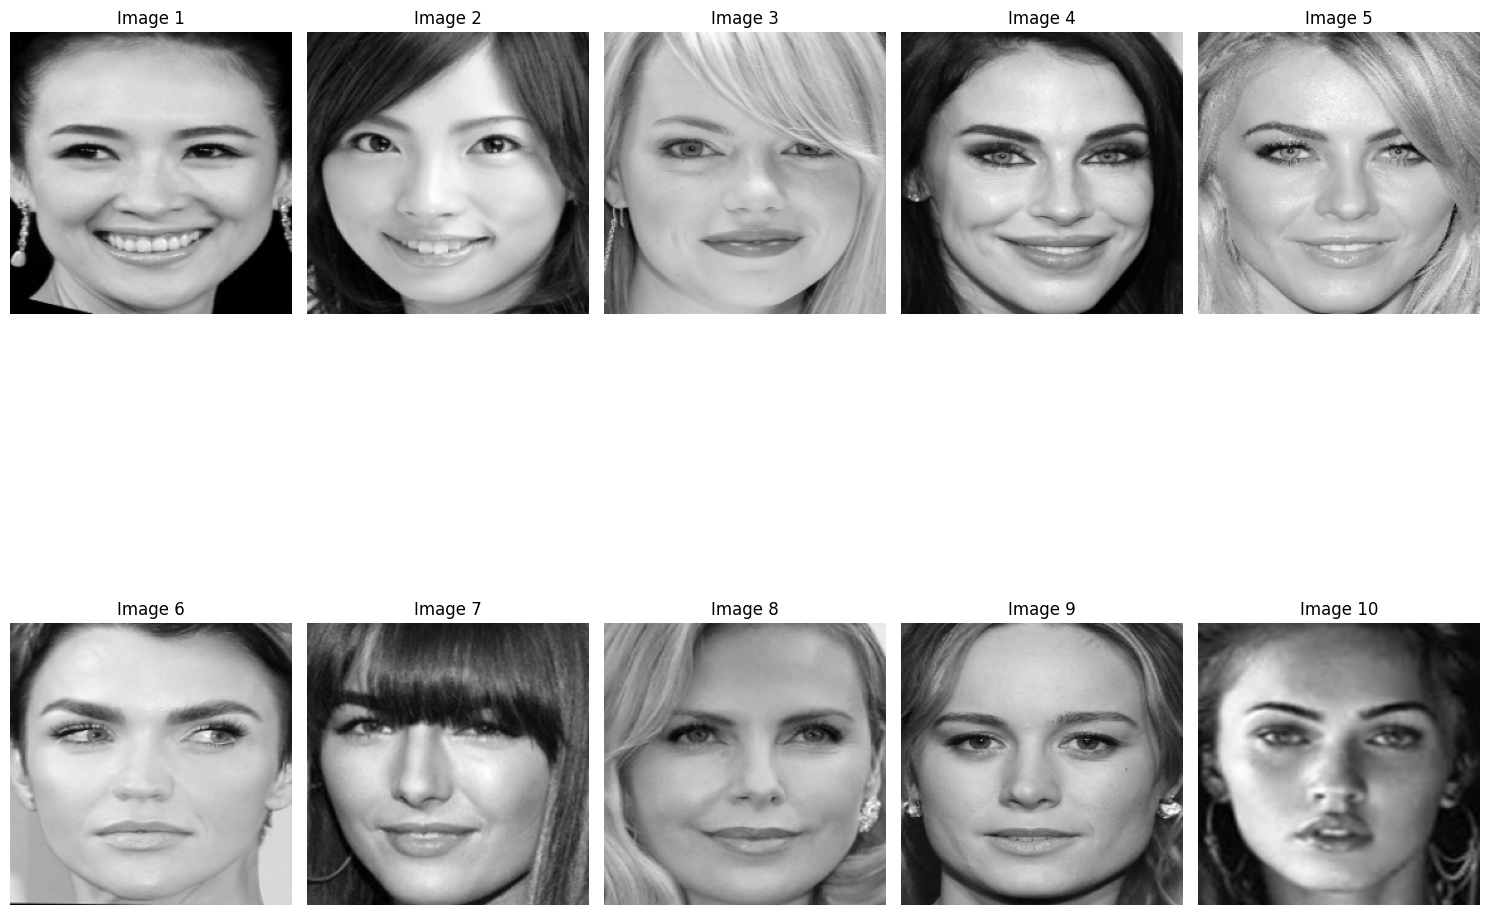

In [30]:
import matplotlib.pyplot as plt

# 이미지 확인 함수
def display_images(image_list, num_images=10):
    # 이미지의 최대 갯수는 num_images로 설정
    fig, axes = plt.subplots(nrows=num_images // 5, ncols=5, figsize=(15, 15))
    axes = axes.ravel()  # 2D 배열을 1D로 변환

    # 리스트에 있는 이미지를 하나씩 출력
    for i in range(min(num_images, len(image_list))):
        img = image_list[i][0]  # 리스트의 첫 번째 값은 이미지
        axes[i].imshow(img, cmap='gray')  # 그레이스케일 이미지 출력
        axes[i].axis('off')  # 축 제거
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# training_data_gray에 있는 이미지 10개 확인
display_images(training_data_gray, num_images=10)

# testing_data_gray에 있는 이미지 10개 확인
display_images(testing_data_gray, num_images=10)


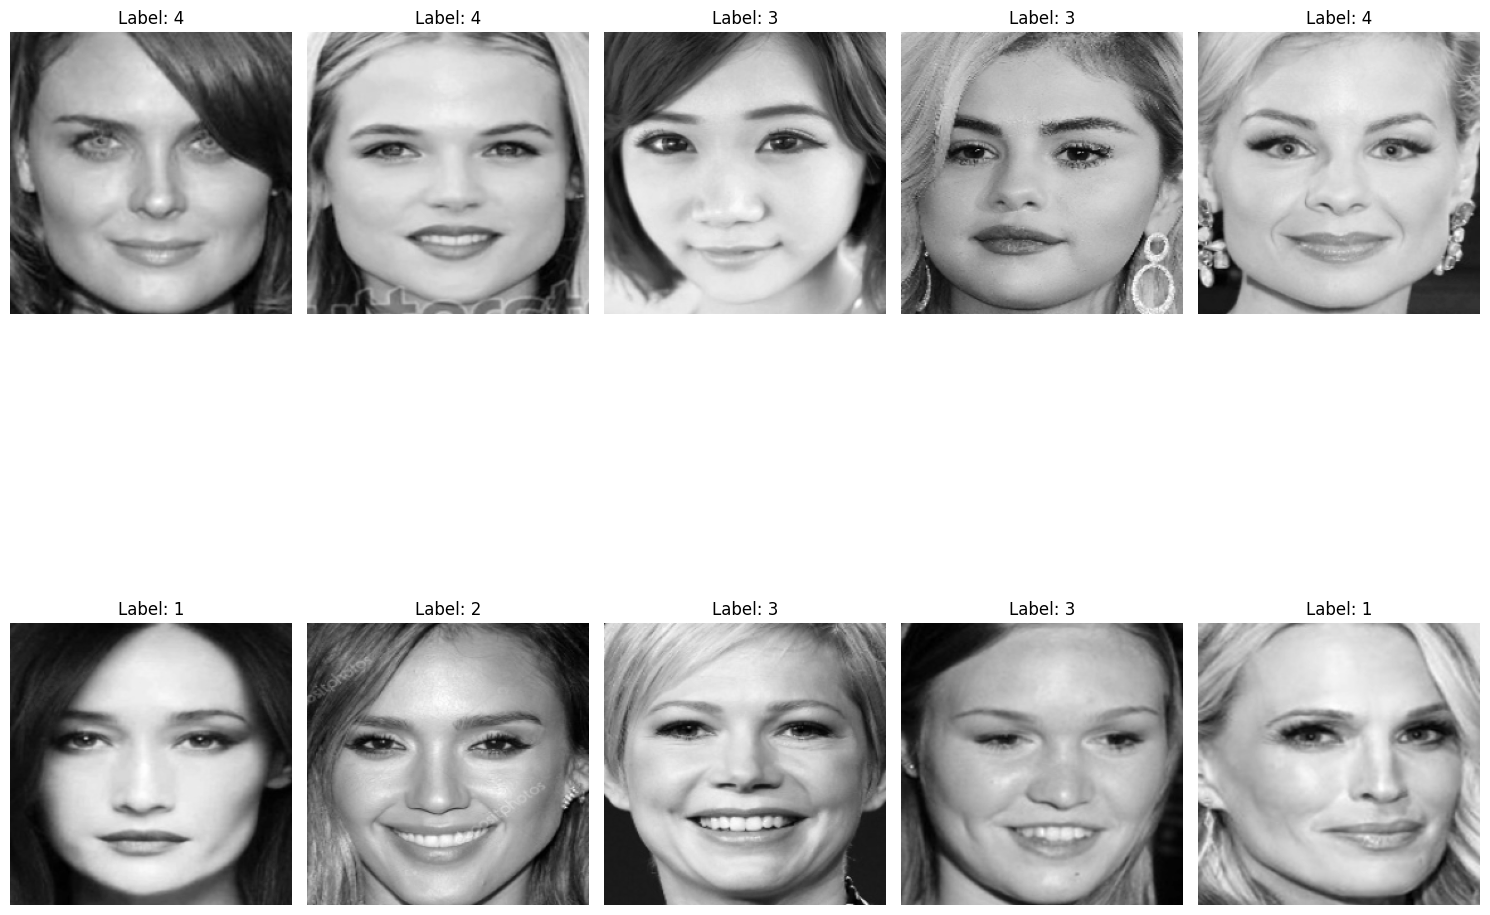

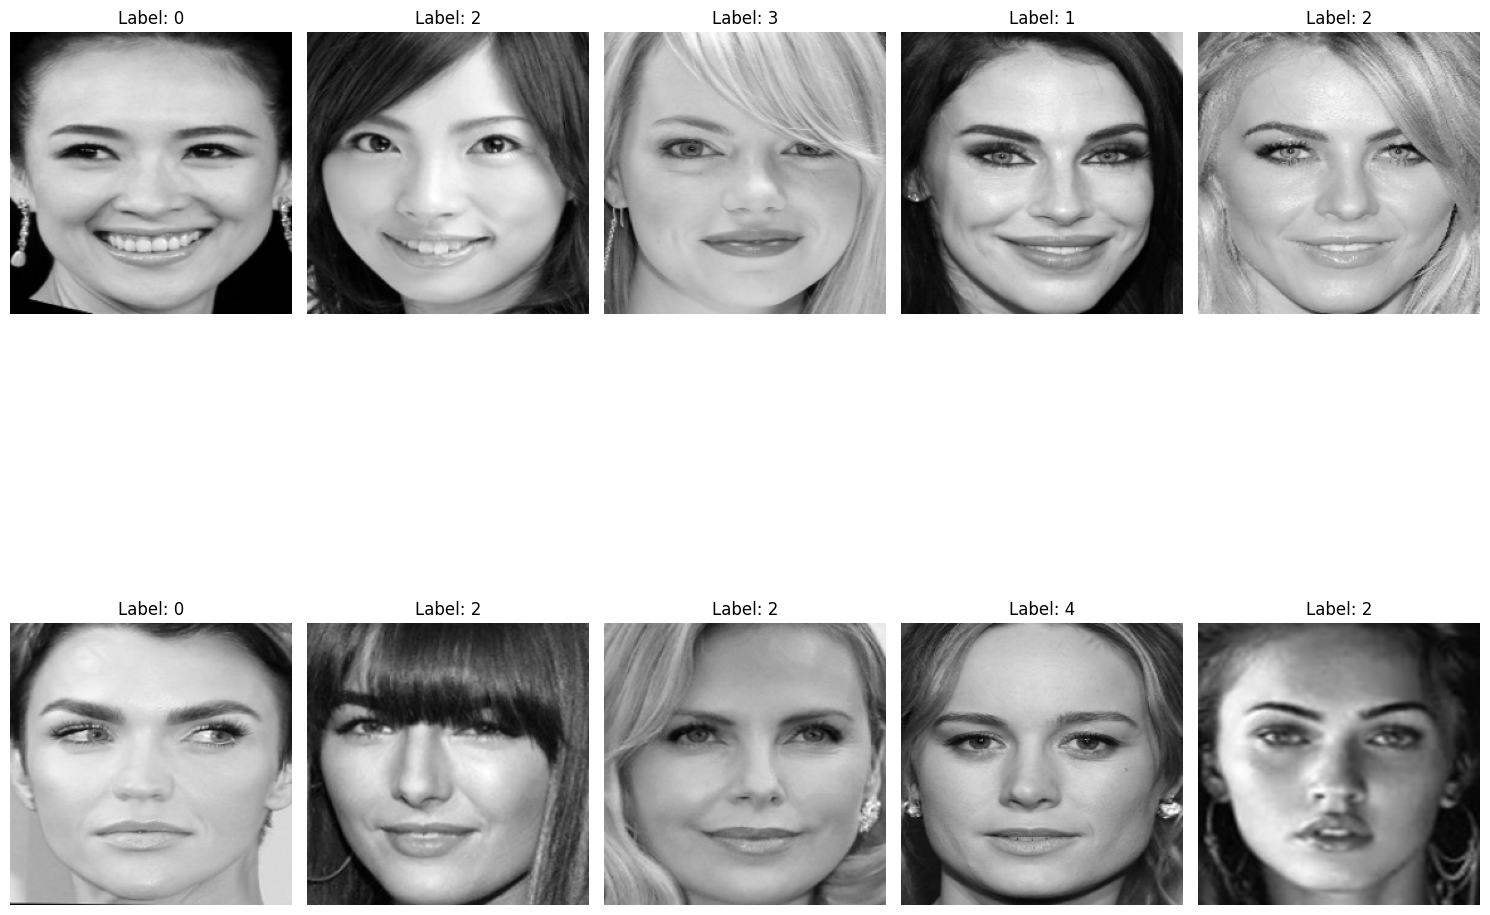

In [31]:
import matplotlib.pyplot as plt

# 이미지와 라벨을 함께 출력하는 함수
def display_images_with_labels(image_list, num_images=10):
    # 이미지의 최대 갯수는 num_images로 설정
    fig, axes = plt.subplots(nrows=num_images // 5, ncols=5, figsize=(15, 15))
    axes = axes.ravel()  # 2D 배열을 1D로 변환

    # 리스트에 있는 이미지를 하나씩 출력
    for i in range(min(num_images, len(image_list))):
        img, label = image_list[i]  # 이미지와 라벨을 가져옴
        axes[i].imshow(img, cmap='gray')  # 그레이스케일 이미지 출력
        axes[i].axis('off')  # 축 제거
        axes[i].set_title(f"Label: {label}")  # 라벨 출력

    plt.tight_layout()
    plt.show()

# training_data_gray에 있는 이미지와 라벨 10개 확인
display_images_with_labels(training_data_gray, num_images=10)

# testing_data_gray에 있는 이미지와 라벨 10개 확인
display_images_with_labels(testing_data_gray, num_images=10)
